In [1]:
### Import dependencies 
import pandas as pd # Adding dataframe functionality
from matplotlib import pyplot as plt # Add plotting functionality
from statistics import mean
import folium, json
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from statsmodels import stats as stats 
import math
from sklearn import linear_model

# Exercise 1

Length of the data: 20220
Fields: 9
date
iso3166-2
RelativeHumiditySurface
SolarRadiation
Surfacepressure
TemperatureAboveGround
Totalprecipitation
UVIndex
WindSpeed


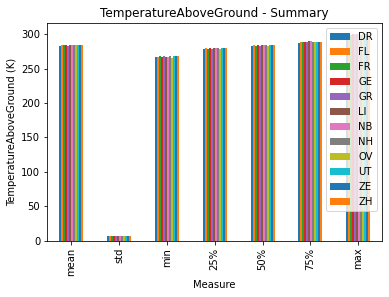

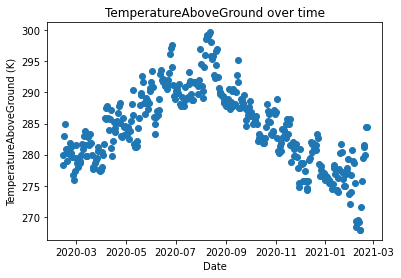

In [2]:
### Read in the weather data from a .csv-file 
weather_data = pd.read_csv("../Data/Raw/weather/weather.csv", sep=",")

### Print the dimensions of the data as well as all the fields 
print(f"Length of the data: {len(weather_data)}")
print(f"Fields: {len(weather_data.columns)}")
for i in weather_data.columns:
    print(i)

### Check for missing values in the data set 
weather_data.isnull().values.any()

### Add two new columns based on the iso3166-2 column to 
### create a "country"-column and a "region"-column
weather_data[["country","region"]]= weather_data["iso3166-2"].str.split("-",expand=True)


### Filter the data based on the country
nl_data = weather_data[weather_data["country"] == "NL"]

### Group data based on region and for each region calculate 
### min, max, mean and median for each numeric column. 
### For each of the regions, write these to a file named after the region
agg_data = nl_data.groupby("region")
for i in agg_data:
    with open(f"{i[0]}_summary.txt","w") as outfile:
        outfile.write(str(i[1].describe()))

### Plot TemperatureAboveGround 
tmp_df = pd.DataFrame()
for i in agg_data:
    tmp = i[1].describe()
    tmp_df[i[0]] = tmp["TemperatureAboveGround"][1:]

tmp_df.plot(kind="bar")
plt.title("TemperatureAboveGround - Summary")
plt.ylabel("TemperatureAboveGround (K)")
plt.xlabel("Measure")
plt.show()

### Group data based on date and calculate means of all 
### numerical columns 
agg_data = nl_data.groupby("date")
mean_data = {}
index = []
for i in agg_data:
    index.append(i[0])
    tmp = i[1].describe()
    for j in tmp:
        if j in mean_data.keys():
            mean_data[j].append(tmp[j]["mean"])
        else:
            mean_data[j] = [tmp[j]["mean"]]
new_data = pd.DataFrame(mean_data,index=index)
new_data.index = pd.to_datetime(new_data.index)

### Plot TemperatureAboveGround v. time 
plt.plot_date(new_data.index, new_data["TemperatureAboveGround"],xdate=True)
plt.title("TemperatureAboveGround over time")
plt.ylabel("TemperatureAboveGround (K)")
plt.xlabel("Date")
plt.show()

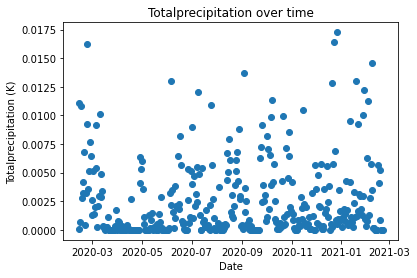

In [3]:
### Plot Totalprecipitation vs. time 
plt.plot_date(new_data.index, new_data["Totalprecipitation"],xdate=True)
plt.title("Totalprecipitation over time")
plt.ylabel("Totalprecipitation (K)")
plt.xlabel("Date")
plt.show()

# Exercise 2

In [4]:
# file paths
nl_coronadata = "../Data/Raw/corona/nl_corona.csv"
nl_metadata = "../Data/Raw/metadata/nl_metadata.json"
nl_geojson = "../Data/Raw/shapefiles/nl.geojson"

## loading corona data, metadata, and geojson data
# corona_df contains corona data
corona_df = pd.read_csv(nl_coronadata, sep = "\t")

# country_metadata contians metadatasuch as region, iso code, etc.
with open(nl_metadata, "r") as f:
    country_metadata = json.load(f)

# geojson contains coordinates for projection
with open(nl_geojson, "r") as f:
    geojson = json.load(f)

In [5]:
## creating a map instance
# location --> determines where the map will be positioned
# zoom_start --> adjusts default zoom level on map
# crs --> a set of functions that allows for coordinate transformations

m = folium.Map(location = [52, 5], zoom_start = 7, crs = "EPSG3857")
m

In [6]:
## creating a data frame grouped by region to find cumulative cases per region
covid_region_map = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
corona_df["iso3166-2"] = corona_df["region_code"].map(covid_region_map)

# finding cumulative cases per region
corona_df_by_region = corona_df.groupby(by = "iso3166-2")["hospitalized_addition"].sum().reset_index()

# adding population to data frame
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"]for i in range(len(country_metadata["country_metadata"]))}
corona_df_by_region["population"] = corona_df_by_region["iso3166-2"].map(population_map)

# adding cases per population to data frame
cases_per_population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: corona_df_by_region["hospitalized_addition"][i]/corona_df_by_region["population"][i] for i in range(len(country_metadata["country_metadata"]))}
corona_df_by_region["cases_per_population"] = corona_df_by_region["iso3166-2"].map(cases_per_population_map)

corona_df_by_region

,iso3166-2,hospitalized_addition,population,cases_per_population
0,NL-DR,363.0,493657,0.000735
1,NL-FL,519.0,422979,0.001227
2,NL-FR,349.0,649944,0.000537
3,NL-GE,2510.0,2086142,0.001203
4,NL-GR,279.0,586061,0.000476
5,NL-LI,2191.0,1117164,0.001961
6,NL-NB,4207.0,2563432,0.001641
7,NL-NH,3662.0,2879611,0.001272
8,NL-OV,1125.0,1162500,0.000968
9,NL-UT,1964.0,1354979,0.001449


In [7]:
## choropleth of cases per region

m_cases = folium.Map(location = [52, 5], zoom_start = 7, crs = "EPSG3857")

folium.Choropleth(
    geo_data = nl_geojson,
    name = "cases",
    data = corona_df_by_region,
    columns = ["iso3166-2", "hospitalized_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "Hospitalized",
).add_to(m_cases)

folium.LayerControl().add_to(m_cases)

m_cases

In [8]:
## choropleth of population per region

m_population = folium.Map(location = [52, 5], zoom_start = 7)

folium.Choropleth(
    geo_data = nl_geojson,
    name = "population",
    data = corona_df_by_region,
    columns = ["iso3166-2", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(m_population)

m_population

In [9]:
## choropleth of cases per population of respective region

m_cases_per_population = folium.Map(location = [52, 5], zoom_start = 7)

folium.Choropleth(
    geo_data = nl_geojson,
    name = "cases per population",
    data = corona_df_by_region,
    columns = ["iso3166-2", "cases_per_population"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(m_cases_per_population)

m_cases_per_population

# Exercise 3

In [10]:
## creating a helper function to keep track of merged data

def merge_data(attr_file): 
    with open(attr_file, "r") as infile:
        attributes = json.load(infile)
    weather_data = pd.read_csv(f'{attributes["Files"]["Base_path"]}{attributes["Files"]["Weather"]}', sep=",")
    if weather_data.isnull().values.any(): 
        return "Missing data"
    weather_data[["country","region"]]= weather_data["iso3166-2"].str.split("-",expand=True)
    weather_data = weather_data[weather_data["country"] == attributes["Country"]]
    corona_data = pd.read_csv(f'{attributes["Files"]["Base_path"]}{attributes["Files"]["Corona"]}', sep="\t")
    with open(f'{attributes["Files"]["Base_path"]}{attributes["Files"]["Metadata"]}') as f:
        country_metadata = json.load(f)
    with open(f'{attributes["Files"]["Base_path"]}{attributes["Files"]["Shapefile"]}') as f: 
        geojson = json.load(f)
    covid_region_map = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
    corona_data["iso3166-2"] = corona_data["region_code"].map(covid_region_map)
    for i in attributes["Replacements"]:
        corona_data["region_name"] = corona_data["region_name"].str.replace(i,attributes["Replacements"][i])
    merged = weather_data.merge(corona_data, on = attributes["Merge"])
    for column in merged.columns: 
        try: 
            merged[column] = merged[column].astype("float")
        except ValueError:
            try: 
                merged[column] = pd.to_datetime(merged[column])
            except ValueError:
                pass 
    merged.replace([np.inf,-np.inf],np.nan,inplace=True)
    merged.dropna(inplace=True)
    
    return merged

In [11]:
## creating the merged dataset using weather and corona attributes
merged = merge_data("../Scripts/attributes.json")

rm = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
merged["region"] = merged["region_code"].map(rm)

pm = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: country_metadata["country_metadata"][i]["population"]for i in range(len(country_metadata["country_metadata"]))}
merged["population"] = merged["region_name"].map(pm)

merged["cases_pc"] = merged["hospitalized_addition"] / merged["population"]

merged = merged.dropna()
merged.replace([np.inf,-np.inf],np.nan,inplace=True)
merged.dropna(inplace=True)

# check if there are any NA values
merged.isna().any()
rows_lost = nl_data.shape[0] - corona_df.shape[0]
print(rows_lost)

merged.isin([np.inf,-np.inf]).values.sum()
merged

for var in merged.columns[2:9]:
    print(var)
    merged[var] = merged[var].astype('float')

156
RelativeHumiditySurface
SolarRadiation
Surfacepressure
TemperatureAboveGround
Totalprecipitation
UVIndex
WindSpeed


In [12]:
v = merged.columns[2:9] 

corr_pearson = {}
corr_spearman = {}
corr_pearson_log = {}

# calculating the pearson correlation
for var in v:
    corr_pearson[var] = pearsonr(merged["hospitalized_addition"], merged[var])
    
# calculating the spearman correlation
for var in v:
    corr_spearman[var] = spearmanr(merged["hospitalized_addition"], merged[var])

# p-values of pearson and spearman
pvals = [corr_pearson[i][0] for i in corr_pearson]
pvals.extend([corr_spearman[i][0] for i in corr_spearman])

## formatting results
print("Pearson correlation results")
for i in corr_pearson.keys():
    print(f"{i}: coef = {corr_pearson[i][0]}, p-value = {corr_pearson[i][1]}")
print()

print("Spearman correlation results")
for i in corr_spearman.keys():
    print(f"{i}: coef = {corr_spearman[i][0]}, p-value = {corr_pearson[i][1]}")
print()

## performing the Bonferroni correction to remove Type I error
b_results, b_p_adjusted, _, b_alpha_adjusted = stats.multitest.multipletests(pvals,alpha=0.05,method="bonferroni")
print("Bonferroni correction")
print(b_p_adjusted.tolist())
print(b_results.tolist())
print()

## performing the Holm-Bonferroni correction to remove Type II error
h_results, h_p_adjusted, _, h_alpha_adjusted = stats.multitest.multipletests(pvals,alpha=0.05,method="holm")
print("Holm-Bonferroni correction")
print(h_p_adjusted.tolist())
print(h_results.tolist())
print()

Pearson correlation results
RelativeHumiditySurface: coef = -0.12630708365813176, p-value = 3.4291289850084983e-16
SolarRadiation: coef = 0.008996045710151255, p-value = 0.5628132309656907
Surfacepressure: coef = 0.09868832971346343, p-value = 1.971973526534879e-10
TemperatureAboveGround: coef = -0.21267134372043806, p-value = 1.4962805851406624e-43
Totalprecipitation: coef = -0.06700045201228051, p-value = 1.5993158024414373e-05
UVIndex: coef = -0.1627641128551993, p-value = 5.65613054999417e-26
WindSpeed: coef = 0.0534480085753619, p-value = 0.0005808187956285361

Spearman correlation results
RelativeHumiditySurface: coef = 0.1220506141047999, p-value = 3.4291289850084983e-16
SolarRadiation: coef = -0.24340132796520916, p-value = 0.5628132309656907
Surfacepressure: coef = 0.024542658885898724, p-value = 1.971973526534879e-10
TemperatureAboveGround: coef = -0.49580245863133826, p-value = 1.4962805851406624e-43
Totalprecipitation: coef = -0.06101268460368233, p-value = 1.59931580244143

# Exercise 4

In [13]:
# mapping covid region code to iso31662_code
rm = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
corona_df["region"] = corona_df["region_code"].map(rm)

# mapping iso31662_code to population
pm = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: country_metadata["country_metadata"][i]["population"]for i in range(len(country_metadata["country_metadata"]))}
corona_df["population"] = corona_df["region_name"].map(pm)

# adding a column 'cases_pc' which shows the number of added hospitalizations relative to the population
corona_df["cases_pc"] = corona_df["hospitalized_addition"] / corona_df["population"]

# merging corona data and weather data 
df = corona_df.merge(nl_data, left_on = ["date", "region"], right_on = ["date", "iso3166-2"])

# dropping some more of the irrelevant variables
df = df.drop(["region_code", "region_y"], axis = 1)

# cleaning data & checking for null values
df = df.dropna()
df.replace([np.inf,-np.inf],np.nan,inplace=True)
df.dropna(inplace=True)
df.isna().any()
df.isin([np.inf,-np.inf]).values.sum()

df = sm.add_constant(df)

#Creating list with all column names and adding a column called 'const' with all values as 1.0
v = []
for i in nl_data.columns:
    v.append(i)
v = v[2:-2]
v.append("const")

# fitting various models on different dependent variables
est = sm.OLS(df["hospitalized_addition"], df[v], hasconst = True).fit()
#print(est.summary())

est = sm.OLS(np.where(df["hospitalized_addition"] > 1.0e-10, np.log(df["hospitalized_addition"]), -10), df[v], hasconst = True).fit()
#print(est.summary())

regions = ["const",]

# creating a list of regions and appending the regions to
for region in set(df["iso3166-2_x"]):
    if region != "DK-81":
        df[region] = (df["iso3166-2_x"] == region).astype(int)
        regions.append(region)
        v.append(region)


est = sm.OLS(df["cases_pc"] , df[v], hasconst = True).fit()
print(est.summary())

est = sm.OLS(np.log(df["cases_pc"] + 1), df[v], hasconst = True).fit()
print(est.summary())

est = sm.OLS(df["Totalprecipitation"], df[regions], hasconst = True).fit()
#print(est.summary())

est = sm.OLS(np.log(df["cases_pc"] + 1), df[v], hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": df["iso3166-2_x"]}, use_t = True)
#print(est.summary())

est = sm.OLS(df["Totalprecipitation"], df[v], hasconst = True).fit()
#print(est.summary())


                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     41.68
Date:                Fri, 04 Mar 2022   Prob (F-statistic):          6.30e-112
Time:                        12:09:32   Log-Likelihood:                 32577.
No. Observations:                3105   AIC:                        -6.512e+04
Df Residuals:                    3089   BIC:                        -6.503e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface -1

C:\Users\desus\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\desus\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Exercise 5

In [14]:
## importing the oxford stringency index data set

stringency = "../Data/Raw/Stringency_Index/stringency.csv"

str_data = pd.read_csv(stringency, sep = ",")
str_data = str_data[1:]

# Dutch country code=NLD
nl_str = str_data[str_data["CountryCode"] == "NLD"]

# converting format of date
nl_str["date"] = pd.to_datetime(nl_str.Date.apply(str).apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8]))

C:\Users\desus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2,3,5,51) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\desus\AppData\Local\Temp/ipykernel_88592/3949567022.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nl_str["date"] = pd.to_datetime(nl_str.Date.apply(str).apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8]))


In [15]:
## merging the data using the correct format of the date

merge_df = merged.merge(nl_str,on=["date"])
merge_df = sm.add_constant(merge_df)
weather = merged[["RelativeHumiditySurface",
                            "SolarRadiation",
                            "Surfacepressure",
                            "TemperatureAboveGround",
                            "Totalprecipitation",
                            "UVIndex",
                            "WindSpeed"]]
corona = merged["cases_pc"]
corona

C:\Users\desus\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in reduce
  result = getattr(ufunc, method)(*inputs, **kwargs)


192     0.000000
193     0.000000
194     0.000000
195     0.000002
196     0.000000
          ...   
4327    0.000004
4328    0.000002
4329    0.000004
4330    0.000000
4331    0.000004
Name: cases_pc, Length: 4140, dtype: float64

In [16]:
## creating a new variable with all the weather variables

weather_vars = ["RelativeHumiditySurface",
                            "SolarRadiation",
                            "Surfacepressure",
                            "TemperatureAboveGround",
                            "Totalprecipitation",
                            "UVIndex",
                            "WindSpeed",
                            "const"]
regions = ["const",]


In [17]:
## fitting weather and cases per region data using a linear regression model

regr = linear_model.LinearRegression()
regr.fit(weather,corona)
coefs = list(regr.coef_)
for i in range(len(weather_vars)-1):
    print(f"{weather_vars[i]} - {coefs[i]}")

RelativeHumiditySurface - -1.9725960509250865e-07
SolarRadiation - 2.1449864080699364e-13
Surfacepressure - 7.19676663830111e-12
TemperatureAboveGround - -1.4590758209812816e-07
Totalprecipitation - 0.00013303034739292328
UVIndex - -2.4558892426840963e-07
WindSpeed - -1.7116588385908968e-07


In [18]:
merge_df["cases_pc"]

0       0.000000
1       0.000000
2       0.000000
3       0.000002
4       0.000000
          ...   
4135    0.000004
4136    0.000002
4137    0.000004
4138    0.000000
4139    0.000004
Name: cases_pc, Length: 4140, dtype: float64

In [19]:
## removing "Date" column

merge_df.drop("Date",inplace=True,axis=1)

In [20]:
## creating a list of varibles included in weather data and stringency index data

columns = list(merge_df.columns)[2:]

for i in range(18): 
    columns.pop(7)
columns = columns[:49]
columns.append("const")

merge_df["const"] = [1]*len(merge_df)

## WHY
columns.pop(41)
columns.pop(41)

print(merge_df['const'])
columns

0       1
1       1
2       1
3       1
4       1
       ..
4135    1
4136    1
4137    1
4138    1
4139    1
Name: const, Length: 4140, dtype: int64


['RelativeHumiditySurface',
 'SolarRadiation',
 'Surfacepressure',
 'TemperatureAboveGround',
 'Totalprecipitation',
 'UVIndex',
 'WindSpeed',
 'C1_Flag',
 'C2_Workplace closing',
 'C2_Flag',
 'C3_Cancel public events',
 'C3_Flag',
 'C4_Restrictions on gatherings',
 'C4_Flag',
 'C5_Close public transport',
 'C5_Flag',
 'C6_Stay at home requirements',
 'C6_Flag',
 'C7_Restrictions on internal movement',
 'C7_Flag',
 'C8_International travel controls',
 'E1_Income support',
 'E1_Flag',
 'E2_Debt/contract relief',
 'E3_Fiscal measures',
 'E4_International support',
 'H1_Public information campaigns',
 'H1_Flag',
 'H2_Testing policy',
 'H3_Contact tracing',
 'H4_Emergency investment in healthcare',
 'H5_Investment in vaccines',
 'H6_Facial Coverings',
 'H6_Flag',
 'H7_Vaccination policy',
 'H7_Flag',
 'H8_Protection of elderly people',
 'H8_Flag',
 'M1_Wildcard',
 'V1_Vaccine Prioritisation (summary)',
 'V2A_Vaccine Availability (summary)',
 'V2D_Medically/ clinically vulnerable (Non-elder

In [21]:
## creating a new data frame with all variables included in the "columns" list

tmp = merge_df[columns]
tmp.replace(np.nan,0,inplace=True)

C:\Users\desus\anaconda3\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [22]:
## using numpy to convert elements in cases per region column into an array

tmp_two = np.asarray(merge_df["cases_pc"])

In [23]:
## OLS regression including stringency index variables

est = sm.OLS(tmp_two, tmp, hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": merge_df["iso3166-2"]}, use_t = True)
print(est.summary())

C:\Users\desus\anaconda3\lib\site-packages\statsmodels\base\model.py:1863: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 14
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                -1.239e+09
Date:                Fri, 04 Mar 2022   Prob (F-statistic):               1.00
Time:                        12:09:33   Log-Likelihood:                 43708.
No. Observations:                4140   AIC:                        -8.736e+04
Df Residuals:                    4110   BIC:                        -8.717e+04
Df Model:                          29                                         
Covariance Type:              cluster                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [24]:
## visualizing coefficients

regr = linear_model.LinearRegression()
regr.fit(tmp,tmp_two)
coef_list = list(regr.coef_)
for i in range(len(columns)):
    print(f"{columns[i]} - {coef_list[i]}")

RelativeHumiditySurface - -1.1431583152618594e-07
SolarRadiation - 1.733769456381542e-13
Surfacepressure - 3.6223223014748024e-12
TemperatureAboveGround - -1.5557524789913464e-07
Totalprecipitation - 1.9071860964536665e-06
UVIndex - -3.7193554638018515e-07
WindSpeed - -1.0377658308027118e-07
C1_Flag - 2.1624059662813126e-10
C2_Workplace closing - 8.543301030647253e-07
C2_Flag - 7.849637616588437e-12
C3_Cancel public events - 9.028164385353075e-07
C3_Flag - 1.1280826651922305e-06
C4_Restrictions on gatherings - -2.714987406366818e-06
C4_Flag - -7.53727203407786e-12
C5_Close public transport - 1.4307138646432934e-06
C5_Flag - 1.4307082500161802e-06
C6_Stay at home requirements - 3.7890178229622537e-06
C6_Flag - 8.470329472543003e-21
C7_Restrictions on internal movement - -3.845230928327095e-08
C7_Flag - -3.845230928331919e-08
C8_International travel controls - -1.6940658945086007e-21
E1_Income support - 2.261654315550812e-06
E1_Flag - 1.0831431656584256e-06
E2_Debt/contract relief - 8.97